#### Train SAC RL model

The SAC (Soft Actor-Critic) algorithm is an off-policy reinforcement learning method designed for continuous action spaces. It combines the benefits of both policy-based and value-based methods and is known for its sample efficiency and stability.  

The actor in SAC is responsible for selecting actions in the environment. It typically uses a neural network to learn a policy that maps observations to continuous actions.  
SAC uses a stochastic policy, which means it outputs a probability distribution over the available actions, often modeled as a Gaussian distribution.  
This stochasticity helps exploration during training.

Critic: SAC also includes two critics, referred to as Q-networks. These networks estimate the state-action value function, providing two independent value estimates.  
Having multiple critics helps stabilize the training process.

SAC collects data by interacting with the environment. The actor's stochastic policy is used to sample actions,  
and these actions are executed in the environment to collect state-action-reward transitions.
SAC uses an experience replay buffer to store and sample past experiences.  
This buffer allows the algorithm to learn from a diverse set of experiences and reduce sample correlations.

SAC employs a variant of the Bellman equation to update the critics. The key innovation in SAC is the use of a "soft" Bellman backup.   
This involves minimizing a loss that aims to make the critics agree with each other and be close to the minimum of the Bellman error.

The actor's policy is updated based on the soft Q-values from the critics. The objective is to maximize the expected reward, including an entropy term.  
The entropy term encourages exploration by discouraging overly deterministic policies.

SAC introduces a temperature parameter that scales the entropy term in the policy update. This temperature parameter can be learned or adjusted during training.  
It helps balance exploration and exploitation by controlling the level of stochasticity in the policy.

These steps are repeated iteratively, allowing the agent to improve its policy and value functions over time. The process continues until convergence or a specified number of iterations.

SAC's main advantages include:

It can handle continuous action spaces efficiently.
It provides a good balance between exploration and exploitation, thanks to the entropy term.
It benefits from experience replay, which reduces sample correlations and enhances learning stability.
It can be used in combination with target value networks for even more stability.

https://arxiv.org/pdf/1801.01290.pdf

In [37]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Oct 19 21:02:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    48W / 400W |   1683MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [38]:
!git clone https://github.com/Merijn68/rl-alm.git

fatal: destination path 'rl-alm' already exists and is not an empty directory.


In [39]:
%cd /content/rl-alm/

/content/rl-alm


In [40]:
!pip install stable_baselines3
!pip install loguru

In [41]:

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tensorboard
import os
import sys
from pathlib import Path
import pandas as pd
from stable_baselines3 import SAC

# Find the root directory by traversing up the directory tree
def find_project_root(current_path):
    if os.path.exists(os.path.join(current_path, "README.md")):
        return current_path
    parent_path = os.path.dirname(current_path)
    if parent_path == current_path:
        raise ValueError("Project root not found.")
    return find_project_root(parent_path)


current_dir = os.getcwd()
print(f"Current dirt: {current_dir}")
project_root = find_project_root(current_dir)
sys.path.append(str(project_root))
sys.path.append(os.path.join(project_root, 'src'))
print(f"Project root: {project_root}")

# # flake8: noqa  # Disable Flake8 for the following block
import gymnasium as gym

from src.models.bank_env import BankEnv
from src.visualization import visualize
import src.models.train as train
from src.tests import test_bankmodel_a2c_train as tests
from src.data.definitions import MODEL_PATH, TENSORBOARD_LOGS, DATA_MODEL_PATH
from src.models.evaluate import evaluate_policy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Current dirt: /content/rl-alm
Project root: /content/rl-alm


##### First test - just take a random walk in the environment.

Each episode consists of 60 months. Each timestep interest rates and swap rates are simulated and the bank enters into new mortgages.  
Each month the actor needs to decide on the funding strategy to fund the bank.

In [42]:
env_id = "bank-v3"
gym.register(id=env_id, entry_point=BankEnv, max_episode_steps=60)


/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment bank-v3 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [43]:
# Random walk in the environment
tests.random_walk(env_id)

2023-10-19 21:03:07.694 | INFO     | src.data.dataset:read_data:45 - reading interest data from ESW.
2023-10-19 21:03:10.044 | INFO     | src.data.dataset:read_data:45 - reading zerocurve data from ESW.


Interest period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-08-01 00:00:00'))
Zerocurve period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-08-01 00:00:00'))
steps: 60, score: -3516


Define the model. For the initial model we use the A2C model.

In [44]:
# from stable_baselines3.common.vec_env import DummyVecEnv

env = gym.make(env_id, render_mode="human")
# env = DummyVecEnv([lambda: env])

# Define a Lineair Learning Rate Scheduler
def linear_schedule(initial_value: float):
    """Linear learning rate schedule."""

    def func(progress_remaining: float) -> float:
        """Progress will decrease from 1 (beginning) to 0."""
        return progress_remaining * initial_value

    return func

initial_lr = 0.001
n_steps = 60
model_name = 'SAC'
ent_coef= 0.001

model = SAC(
        "MultiInputPolicy",
        env,
        tensorboard_log=TENSORBOARD_LOGS,
        verbose=1,
        learning_rate=linear_schedule(initial_lr),
        ent_coef='auto',
        use_sde = True, # Use generalized State Dependent Exploration (gSDE) instead of action noise exploration,
        device='cuda'
    )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2023-10-19 21:03:14.162 | INFO     | src.data.dataset:read_data:45 - reading interest data from ESW.
2023-10-19 21:03:15.931 | INFO     | src.data.dataset:read_data:45 - reading zerocurve data from ESW.


Interest period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-08-01 00:00:00'))
Zerocurve period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-08-01 00:00:00'))
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


##### Train the model in the environment and save it

In [45]:
steps = 600_000

model, mean, episode_iqr, episode_cvar, episode_rewards = train.train( model, env, total_timesteps=steps, conf_level=0.95, tb_log_name= TENSORBOARD_LOGS)
modelpath = Path(
        MODEL_PATH,
        model_name + "_" + str(steps) + ".zip",
    )
model.save(modelpath)
pd.DataFrame(episode_rewards).to_csv(Path(DATA_MODEL_PATH, model_name + "_" + str(steps) + ".csv"))

# episode_rewards = env.unwrapped.episode_rewards

Logging to /content/rl-alm/tensorboard_logs_1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.reset_episode_statistics to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reset_episode_statistics` for environment variables or `env.get_wrapper_attr('reset_episode_statistics')` that will search the reminding wrappers.
  logger.warn(


Streaming output truncated to the last 5000 lines.
| time/              |          |
|    episodes        | 8892     |
|    fps             | 62       |
|    time_elapsed    | 8600     |
|    total_timesteps | 533520   |
| train/             |          |
|    actor_loss      | -572     |
|    critic_loss     | 758      |
|    ent_coef        | 0.375    |
|    ent_coef_loss   | -5.71    |
|    learning_rate   | 0.000111 |
|    n_updates       | 533419   |
|    std             | 0.0542   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 60       |
|    ep_rew_mean     | 1.23e+03 |
| time/              |          |
|    episodes        | 8896     |
|    fps             | 62       |
|    time_elapsed    | 8605     |
|    total_timesteps | 533760   |
| train/             |          |
|    actor_loss      | -559     |
|    critic_loss     | 2.57e+03 |
|    ent_coef        | 0.376    |
|    ent_coef_loss   | -3.71   

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.episode_rewards to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.episode_rewards` for environment variables or `env.get_wrapper_attr('episode_rewards')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/base_class.py:845: ResourceWarning: unclosed file <_io.BufferedWriter name='/content/rl-alm/models/SAC_600000.zip'>
  save_to_zip_file(path, data=data, params=params_to_save, pytorch_variables=pytorch_variables)


Model name: SAC, Steps: 600000, Mean: 1118.0598, IQR: 232.0, CVaR: -2176.178947368421


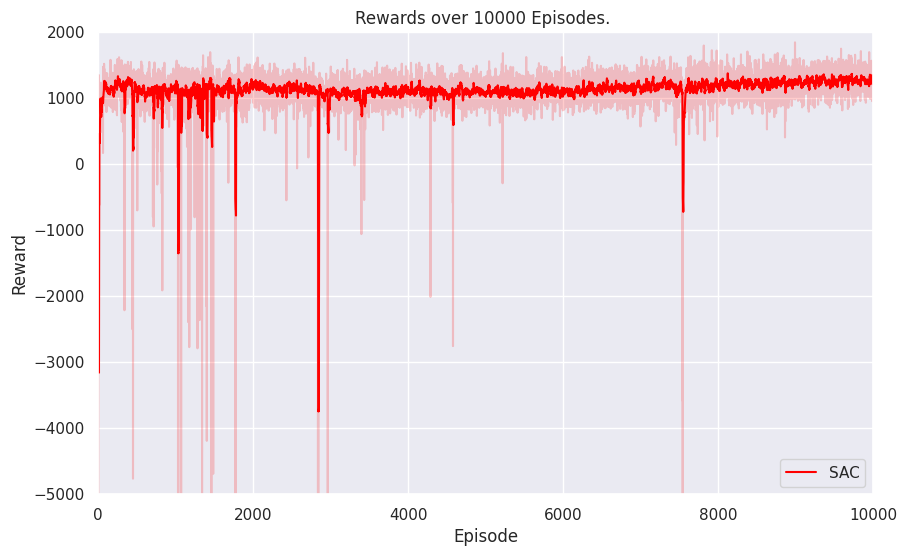

In [46]:
print(f"Model name: {model_name}, Steps: {steps}, Mean: {mean}, IQR: {episode_iqr}, CVaR: {episode_cvar}")
visualize.plot_rewards(episode_rewards, interpolate_line=False, rolling_line= True, ylim=(-5000,2000),
                       label = model_name, title = f"Rewards over {int(steps/60)} Episodes. ")

In [47]:
print(model.policy)

MultiInputPolicy(
  (actor): Actor(
    (features_extractor): CombinedExtractor(
      (extractors): ModuleDict(
        (liquidity): Flatten(start_dim=1, end_dim=-1)
        (cashflows): Flatten(start_dim=1, end_dim=-1)
        (swap_rates): Flatten(start_dim=1, end_dim=-1)
        (bank_rates): Flatten(start_dim=1, end_dim=-1)
        (features): Flatten(start_dim=1, end_dim=-1)
      )
    )
    (latent_pi): Sequential(
      (0): Linear(in_features=52, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
    )
    (mu): Sequential(
      (0): Linear(in_features=256, out_features=4, bias=True)
      (1): Hardtanh(min_val=-2.0, max_val=2.0)
    )
  )
  (critic): ContinuousCritic(
    (features_extractor): CombinedExtractor(
      (extractors): ModuleDict(
        (liquidity): Flatten(start_dim=1, end_dim=-1)
        (cashflows): Flatten(start_dim=1, end_dim=-1)
        (swap_rates): Flatten(start_dim=1, end_d

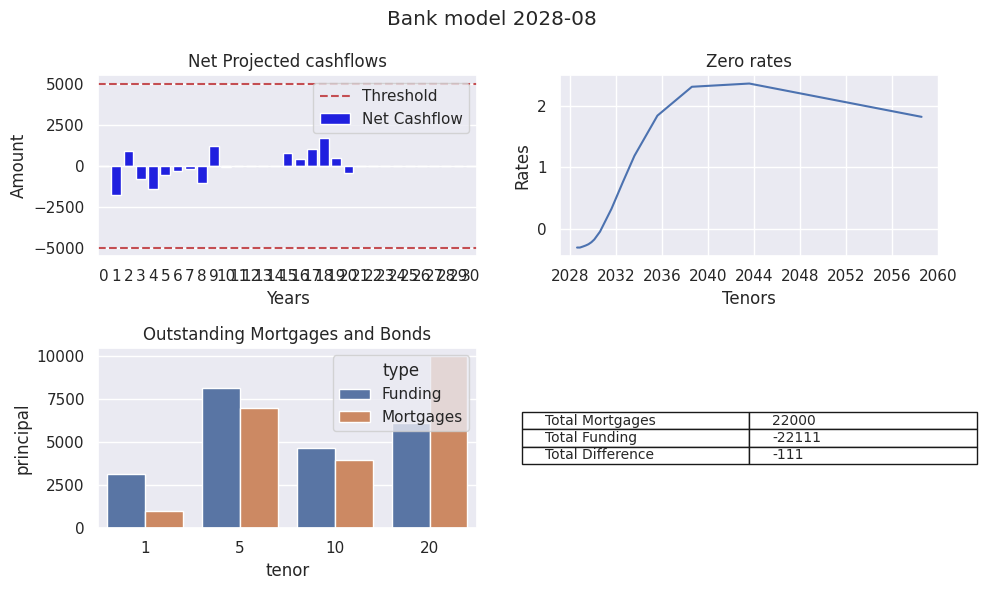

final score:  979


,timestep,reward,risk_penalty,liquidity_penalty,liquidity,nii,income,funding_cost,total_funding,total_mortgages
0,1,-1,0,0,659.051369,-1,0.000000,-1.316670,-658,0
1,2,0,0,0,315.308491,0,2.955517,-2.474807,-1313,1000
2,3,0,0,0,574.690802,0,2.955517,-2.966029,-1570,1000
3,4,0,0,0,878.417234,0,2.955517,-3.509512,-1872,1000
4,5,1,0,0,164.196029,1,5.764855,-3.986750,-2155,2000
5,6,1,0,0,578.387347,1,5.764855,-4.641687,-2567,2000
6,7,0,0,0,971.726595,0,5.764855,-5.202582,-2958,2000
7,8,0,0,0,1322.733097,0,5.764855,-5.649926,-3307,2000
8,9,2,0,0,645.194618,2,8.739070,-6.007547,-3627,3000
9,10,2,0,0,1090.554804,2,8.739070,-6.486499,-4071,3000


In [48]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def show_model(env, model) -> int:
    """Show the model in the environment"""
    # env.set_render_output(modelpath.stem)
    obs, info = env.reset()
    score = 0
    terminated = False
    truncated = False
    # env.set_render_output('A2C')

    while not terminated and not truncated:
        action, _state = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        score = score + reward
        # env.render()
        df = env.list_model()
    env.plot()
    env.close()
    return score, df

score, df = show_model(env, model)

warnings.filterwarnings("default")

print ('final score: ', score)
df.head(60)

In [49]:
mean_reward, irq, es, rewards = evaluate_policy(model, env, n_eval_episodes=500)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
print(f"number of episodes = {len(rewards)}, mean_reward={mean_reward:.2f} Expected Shortfall={es:.2f} Interquartile Range={irq:.2f}")

number of episodes = 500, mean_reward=1053.28 Expected Shortfall=722.60 Interquartile Range=187.00


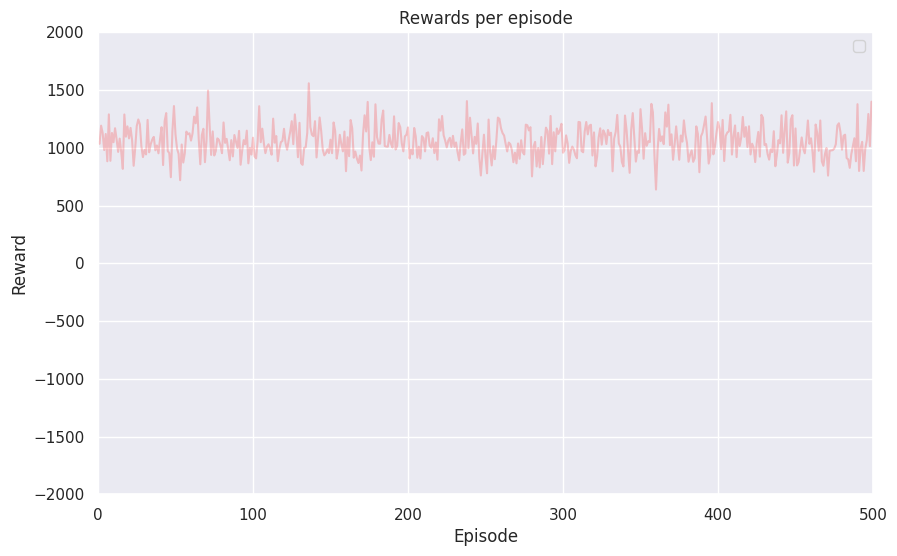

In [51]:
visualize.plot_rewards(rewards, interpolate_line=False)